In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
from torch.distributions.multivariate_normal import MultivariateNormal


import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models_v2 import *
from torchcfm.utils import *
from torchcfm.optimal_transport import OTPlanSampler

from tqdm import tqdm

savedir = "models/lin_pot_8gauss_moon"
os.makedirs(savedir, exist_ok=True)



In [2]:
# Problem set up

dim = 2
batch_size = 256
n_iters = 25_000
ot_sampler = OTPlanSampler(method="exact")

In [3]:
mean = torch.zeros(dim)
cov = torch.eye(dim)

# Set up for reference distribution

ref_dist = MultivariateNormal(mean, cov)


In [4]:
sigma = 0.25
U = torch.tensor([[3, 1], [0, 5]], dtype=torch.float32)
sqt_tr_U = torch.sqrt(torch.trace(U))
D,Q = torch.linalg.eigh(U)
# model_ent_match = ResNet(dim= dim,hidden=2,time_varying= True)
model_harmonic = MLP(dim= dim,w=128,time_varying= True)
optimizer = torch.optim.Adam(model_harmonic.parameters())#, lr=1e-3)

Loss: 44013.652:   0%|          | 0/25000 [00:00<?, ?it/s]

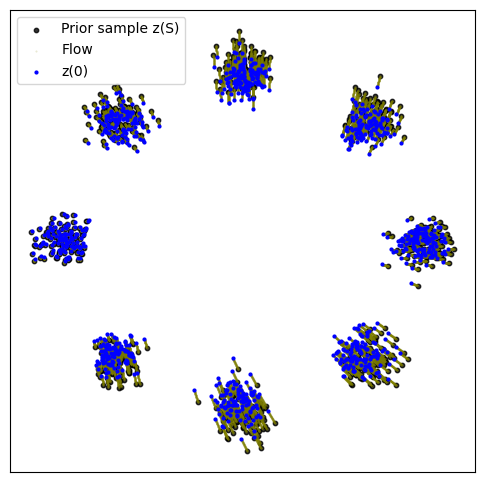

Loss: 1554.852:  20%|██        | 5000/25000 [01:26<05:41, 58.59it/s] 

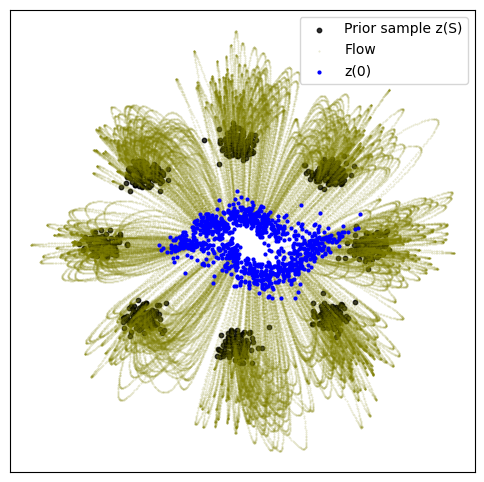

Loss: 2100.699:  40%|████      | 10000/25000 [02:52<04:10, 59.83it/s]

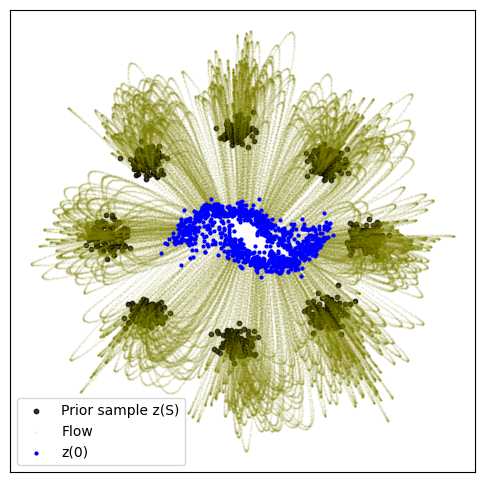

Loss: 1936.874:  60%|██████    | 15001/25000 [04:18<02:45, 60.47it/s]

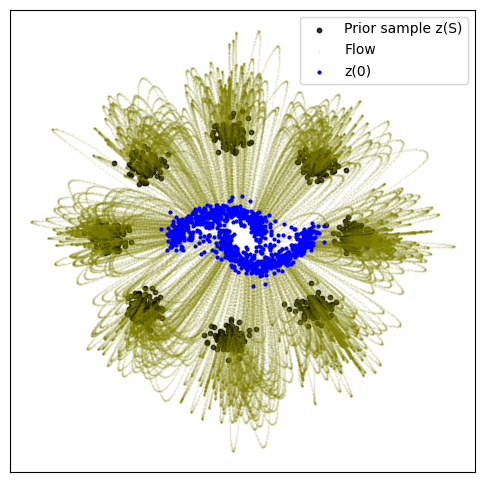

Loss: 1494.113:  80%|████████  | 20000/25000 [05:44<01:24, 59.42it/s]

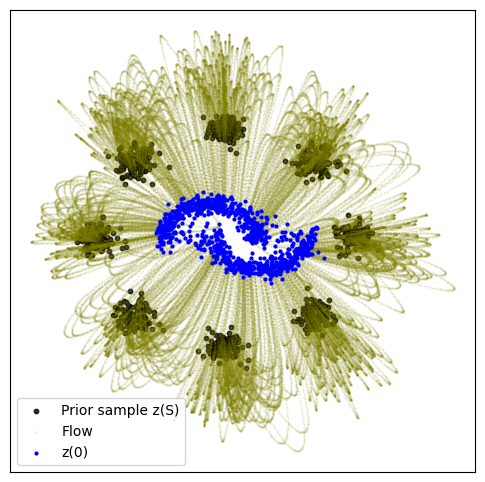

100%|██████████| 25000/25000 [07:12<00:00, 57.79it/s]0:00, 59.38it/s]


In [5]:

# FM = HarmonicOscillatorConditionalFlowMatcher(U = U,sigma= sigma,ot_method= "exact")
pbar = tqdm(total=n_iters, desc="Training")
for k in tqdm(range(n_iters)):
    optimizer.zero_grad()

    t = torch.rand((batch_size,1))

    #x0 = ref_dist.sample((batch_size,))
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    x0, x1 = ot_sampler.sample_plan(x0, x1)

    x0 = x0.unsqueeze(-1)
    x1 = x1.unsqueeze(-1)
    

    D_t = D**0.5 * t
    cos_D_t = torch.diag_embed(torch.cos(D_t))
    sin_D_t = torch.diag_embed(torch.sin(D_t))
    cos_D_1 = torch.diag(torch.cos(D**.5))
    inv_sin_D_1 = torch.diag(torch.sin(D**.5)**-1)

    mu_t = (Q@(cos_D_t@Q.T@x0 + sin_D_t@inv_sin_D_1@(-cos_D_1@Q.T@x0+Q.T@x1))).squeeze(-1)
    mu_t_prime = (Q@torch.diag_embed(D**.5)@(-sin_D_t@Q.T@x0 + cos_D_t@inv_sin_D_1@(-cos_D_1@Q.T@x0+Q.T@x1))).squeeze(-1)

    sig_t = sigma*(torch.cos(sqt_tr_U*t) + torch.sin(sqt_tr_U*t)*(1-torch.cos(sqt_tr_U))/(torch.sin(sqt_tr_U)+1e-8))

    sig_t_prime = sigma*sqt_tr_U*(-torch.sin(sqt_tr_U*t) + torch.cos(sqt_tr_U*t)*(1-torch.cos(sqt_tr_U))/(torch.sin(sqt_tr_U)+1e-8))
    epsilon = torch.randn_like(x0).squeeze(-1)
    
    xt = mu_t + sig_t*epsilon
    ut = sig_t_prime*(xt-mu_t)/(sig_t+1e-8) + mu_t_prime


    vt = model_harmonic(torch.cat([xt,t],dim = -1))
    loss = torch.mean(torch.norm(vt - ut)**2)

    # Update the progress bar
    pbar.set_description("Loss: %.3f" % loss.item())
    pbar.update()
    

    loss.backward()
    optimizer.step()

    if (k ) % 5000 == 0:
        node = NeuralODE(
            torch_wrapper(model_harmonic), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                #ref_dist.sample((1000,)),
                sample_8gaussians(1000),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())



Loss: 1269.401: 100%|██████████| 25000/25000 [07:30<00:00, 59.38it/s]

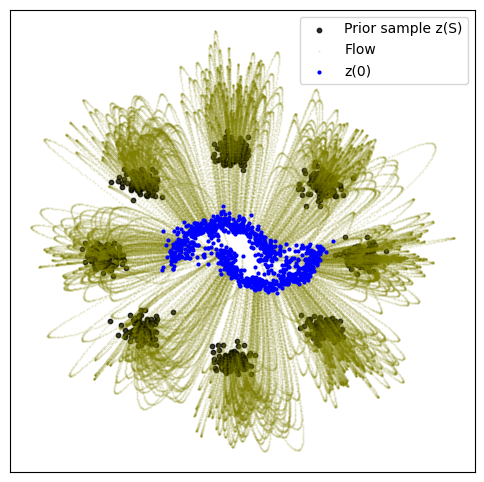

In [7]:
node = NeuralODE(torch_wrapper(model_harmonic), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
with torch.no_grad():
    traj = node.trajectory(
                #ref_dist.sample((1000,)),
                sample_8gaussians(1000),
                t_span=torch.linspace(0, 1, 100),
            )
    plot_trajectories(traj.cpu().numpy())

In [46]:
t = torch.linspace(0,1,batch_size).unsqueeze(-1)

x0 = sample_8gaussians(batch_size)
x1 = sample_moons(batch_size)

# x0, x1 = ot_sampler.sample_plan(x0, x1)

x0 = x0.unsqueeze(-1)
x1 = x1.unsqueeze(-1)


D_t = D**0.5 * t
cos_D_t = torch.diag_embed(torch.cos(D_t))
sin_D_t = torch.diag_embed(torch.sin(D_t))
cos_D_1 = torch.diag(torch.cos(D**.5))
inv_sin_D_1 = torch.diag(torch.sin(D**.5)**-1)

mu_t = (Q@(cos_D_t@Q.T@x0 + sin_D_t@inv_sin_D_1@(-cos_D_1@Q.T@x0+Q.T@x1))).squeeze(-1)
mu_t_prime = (Q@(-sin_D_t@torch.diag_embed(D_t)@Q.T@x0 + cos_D_t@torch.diag_embed(D_t)@inv_sin_D_1@(-cos_D_1@Q.T@x0+Q.T@x1))).squeeze(-1)

sig_t = sigma*(torch.cos(sqt_tr_U*t) + torch.sin(sqt_tr_U*t)*(1-torch.cos(sqt_tr_U))/(torch.sin(sqt_tr_U)+1e-8))

sig_t_prime = sigma*sqt_tr_U*(-torch.sin(sqt_tr_U*t) + torch.cos(sqt_tr_U*t)*(1-torch.cos(sqt_tr_U))/(torch.sin(sqt_tr_U)+1e-8))
epsilon = torch.randn_like(x0).squeeze(-1)

xt = mu_t

In [48]:
x0.shape,mu_t.shape,sig_t.shape,epsilon.shape

(torch.Size([256, 2, 1]),
 torch.Size([256, 2]),
 torch.Size([256, 1]),
 torch.Size([256, 2]))

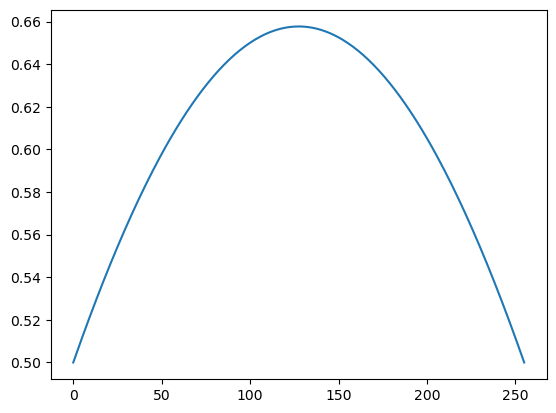

In [56]:
plt.plot(sig_t.squeeze(-1).detach().numpy())    
plt.show()

In [53]:
x1[-1]

tensor([[5.1213],
        [0.6213]])

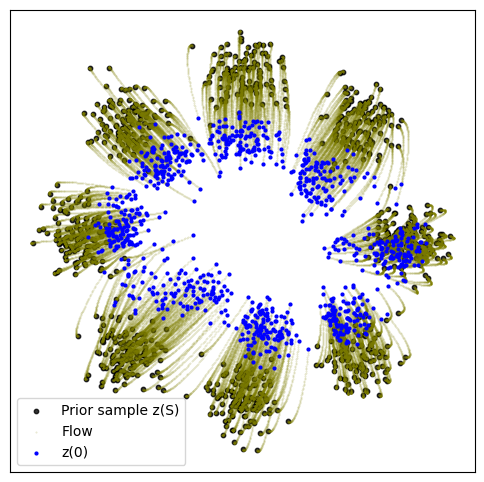